In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
%tensorflow_version 1.x

Mounted at /content/drive
TensorFlow 1.x selected.


In [2]:
!pip install tiffile


!pip install gputools


!pip install vollseg
!pip install n2v

     |████████████████████████████████| 378kB 4.9MB/s 
ERROR: n2v 0.2.1 has requirement keras<2.3.0,>=2.2.4, but you'll have keras 2.3.1 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
  Using cached https://files.pythonhosted.org/packages/f8/ba/2d058dcf1b85b9c212cc58264c98a4a7dd92c989b798823cc5690d062bb2/Keras-2.2.5-py2.py3-none-any.whl
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [3]:

# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
import os

from csbdeep.utils import plot_history,plot_some
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

Using TensorFlow backend.


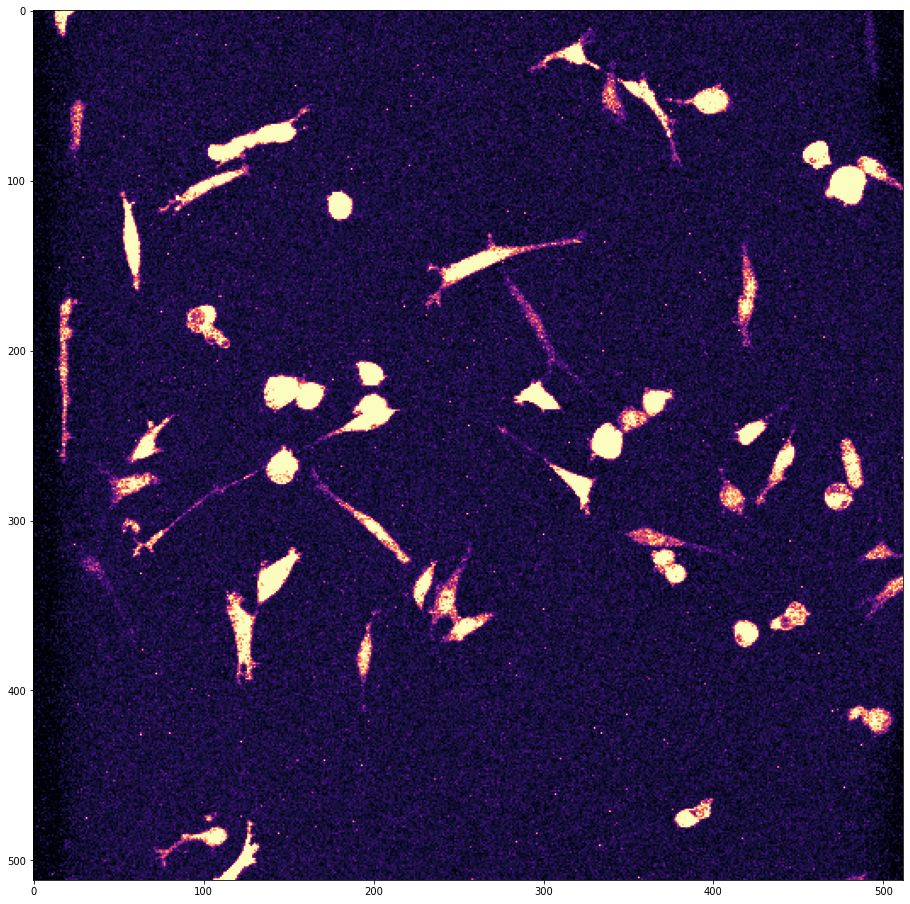

In [4]:
BaseDir = '/content/drive/My Drive/data/'

Model_Dir = '/content/drive/My Drive/data/'
Model_Name = 'ScipyDenoising'
datagen = N2V_DataGenerator()

imgs = datagen.load_imgs_from_directory(directory = BaseDir + "Raw/", dims='ZYX')
plt.figure(figsize=(32,16))
plt.imshow(np.max(imgs[0][0,...,0],axis=0), 
           cmap='magma',
           vmin=np.percentile(imgs[0],0.1),
           vmax=np.percentile(imgs[0],99.9)
          )
plt.show()





Generated patches: (128, 16, 128, 128, 1)
(128, 16, 128, 128, 1)


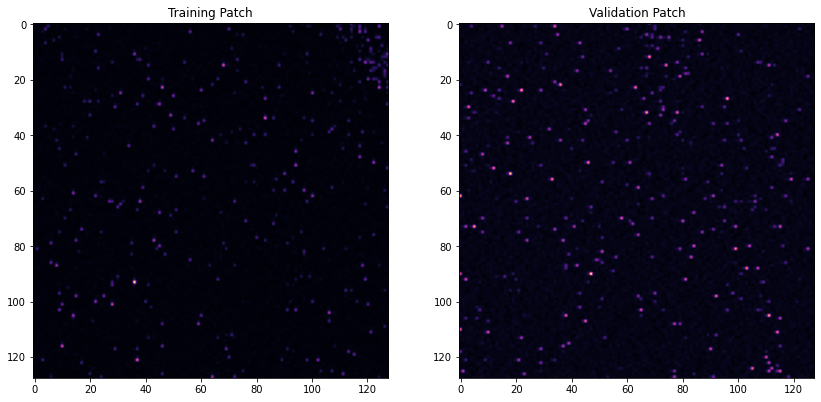

In [5]:
patch_shape = (16, 128, 128)
Epochs = 200
NetworkDepth = 3
batch_size = 1
patches = datagen.generate_patches_from_list(imgs[:1], shape=patch_shape)
print(patches.shape)
X = patches[:120]
X_val = patches[120:]

# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,4,...,0],cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,4,...,0],cmap='magma')
plt.title('Validation Patch');

In [6]:
config = N2VConfig(X, unet_kern_size=3, unet_n_depth = NetworkDepth,
                   train_steps_per_epoch=400,train_epochs= Epochs, train_loss='mse', batch_norm=True, 
                   train_batch_size=batch_size, n2v_perc_pix=0.198,n2v_patch_shape= patch_shape, 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=4)

# Let's look at the parameters stored in the config-object.
vars(config)
model = N2V(config=config, name=Model_Name, basedir=BaseDir)

/usr/local/lib/python3.7/dist-packages/n2v/models/n2v_standard.py:428: UserWarning: output path for model already exists, files may be overwritten: /content/drive/My Drive/data/ScipyDenoising
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


In [ ]:

history = model.train(X, X_val)

Preparing validation data: 100%|██████████| 8/8 [00:00<00:00, 636.54it/s]

519 blind-spots will be generated per training patch of size (16, 128, 128).










The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/200
400/400 [==============================] - 1400s 4s/step - loss: 0.5376 - n2v_mse: 0.5376 - n2v_abs: 0.3299 - val_loss: 0.1943 - val_n2v_mse: 0.1943 - val_n2v_abs: 0.2342

Epoch 2/200
400/400 [==============================] - 1413s 4s/step - loss: 0.5038 - n2v_mse: 0.5038 - n2v_abs: 0.3088 - val_loss: 0.2070 - val_n2v_mse: 0.2070 - val_n2v_abs: 0.2404
Epoch 3/200
400/400 [==============================] - 1408s 4s/step - loss: 0.5303 - n2v_mse: 0.5303 - n2v_abs: 0.3092 - val_loss: 0.1686 - val_n2v_mse: 0.1686 - val_n2v_abs: 0.2120
Epoch 4/200
400/400 [==============================] - 1420s 4s/step - loss

In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

In [ ]:
plt.figure(figsize=(25,7))
_P = model.keras_model.predict(X_val[:5])

plot_some(X_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: denoised),  '
             );